### START FROM HERE

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from pathlib import Path
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import pandas as pd

In [6]:
# === 1. Load road network shapefile ===
road_path = Path("C:/Users/Ardo/Desktop/thesis2/BCN_GrafVial_Trams_ETRS89_SHP.shp")
roads_gdf = gpd.read_file(road_path)

# Project to EPSG:25831 (meters)
if roads_gdf.crs is None or roads_gdf.crs.to_epsg() != 25831:
    roads_gdf = roads_gdf.to_crs(epsg=25831)

# Keep only valid line geometries
roads_gdf = roads_gdf[roads_gdf.geometry.type.isin(["LineString", "MultiLineString"])].copy()

# === 2. Load building footprints ===
buildings_path = Path("C:/Users/Ardo/Desktop/thesis2/Barcelona.geojson")
buildings_gdf = gpd.read_file(buildings_path)

# Project to EPSG:25831 to match roads
if buildings_gdf.crs is None or buildings_gdf.crs.to_epsg() != 25831:
    buildings_gdf = buildings_gdf.to_crs(epsg=25831)

# === 3. Load trees ===
tree_path = Path("C:/Users/Ardo/Desktop/thesis2/bcn_trees.geojson")
trees_gdf = gpd.read_file(tree_path)

# Ensure trees are projected to EPSG:25831
if trees_gdf.crs is None or trees_gdf.crs.to_epsg() != 25831:
    trees_gdf = trees_gdf.to_crs(epsg=25831)

# ✅ Clean height column
trees_gdf["height"] = pd.to_numeric(trees_gdf["height"], errors="coerce")
trees_gdf["height"] = trees_gdf["height"].fillna(0)


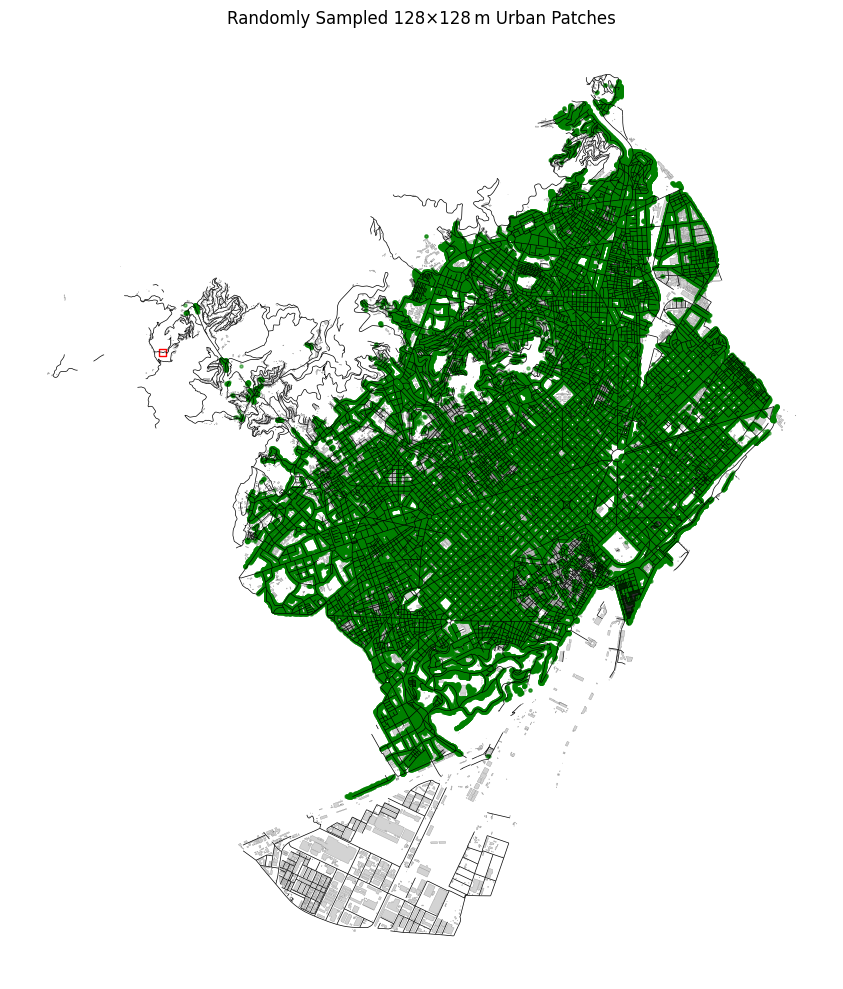

In [7]:
# === 4. Sample 10 random streets ===
sampled_roads = roads_gdf.sample(n=10, random_state=42).copy()

# === 5. Create 128×128 m square patches around street midpoints ===
half_size = 64  # meters (half of 128)
windows = []
ids = []

for _, row in sampled_roads.iterrows():
    geom = row.geometry
    if geom.length == 0:
        continue
    midpoint = geom.interpolate(0.5, normalized=True)
    x, y = midpoint.x, midpoint.y
    square = box(x - half_size, y - half_size, x + half_size, y + half_size)
    windows.append(square)
    ids.append(row["C_Tram"])

windows_gdf = gpd.GeoDataFrame({'C_Tram': ids, 'geometry': windows}, crs=roads_gdf.crs)

# === (Optional) Visual check ===
ax = windows_gdf.plot(facecolor="none", edgecolor="red", linewidth=1, figsize=(10, 10))
roads_gdf.plot(ax=ax, color="black", linewidth=0.5)
buildings_gdf.plot(ax=ax, facecolor="lightgray", edgecolor="gray", linewidth=0.2)
trees_gdf.plot(ax=ax, color="green", markersize=5, alpha=0.5)
plt.title("Randomly Sampled 128×128 m Urban Patches")
plt.axis("off")
plt.tight_layout()
plt.show()

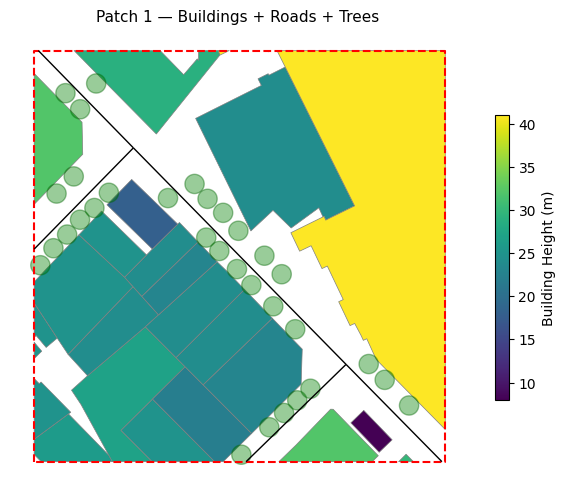

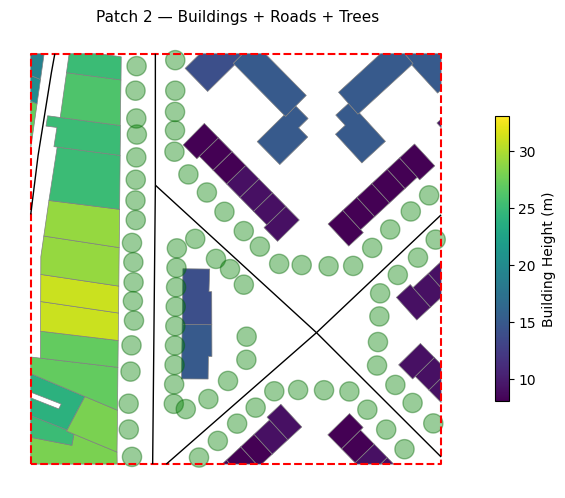

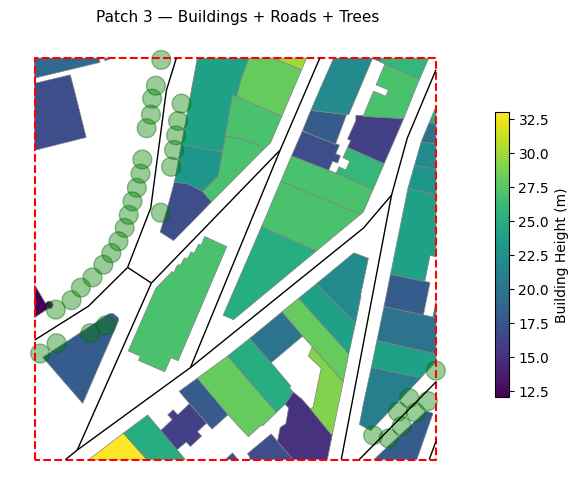

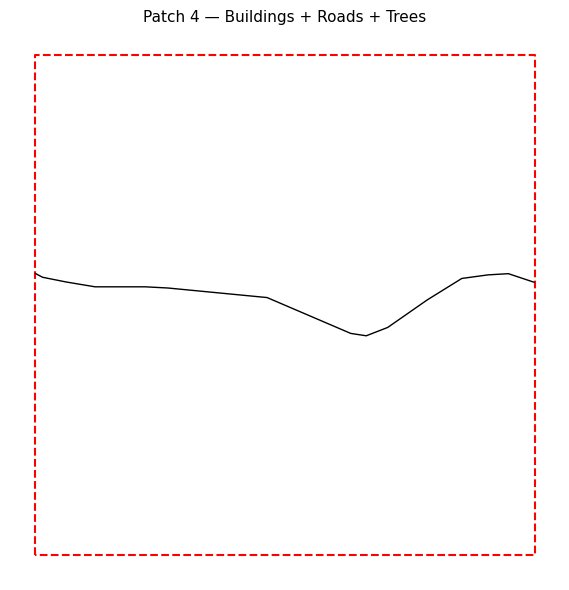

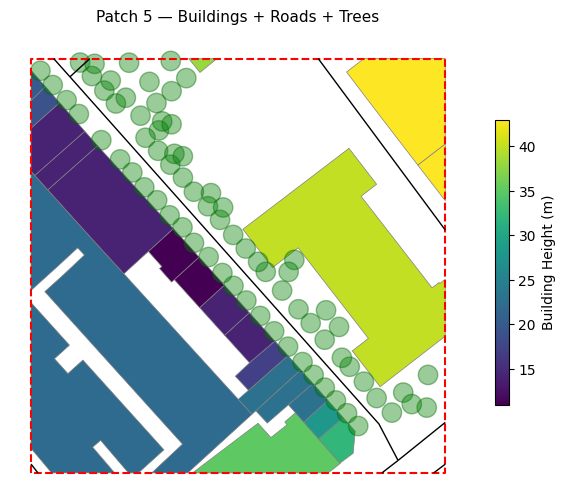

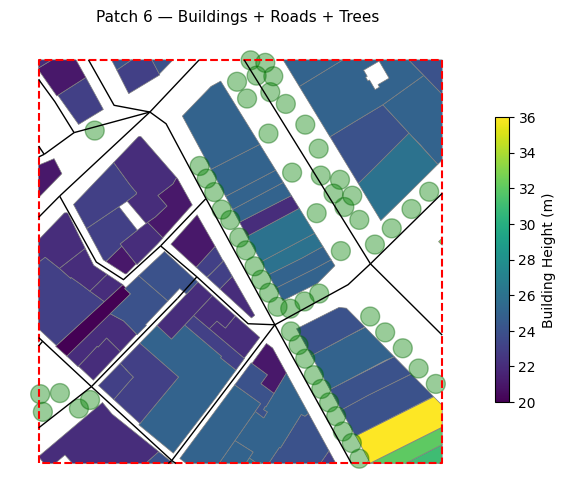

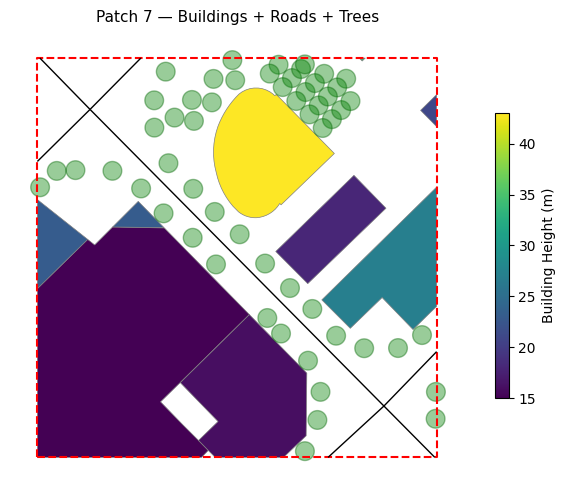

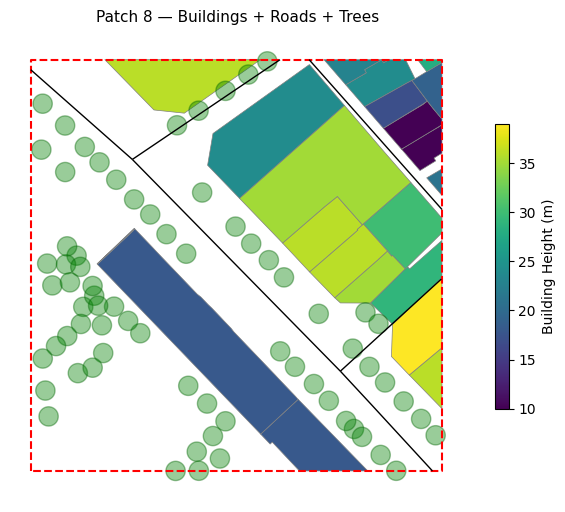

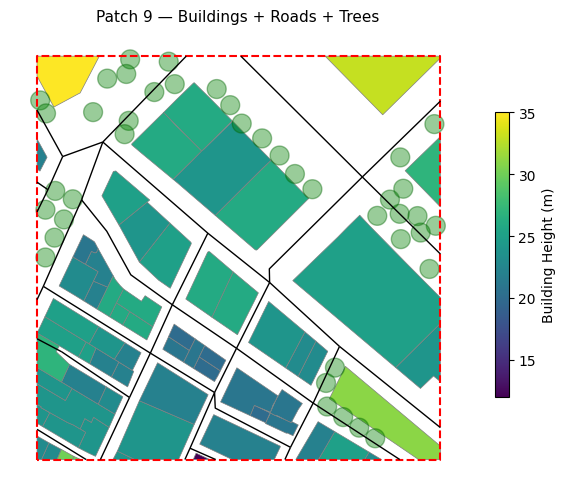

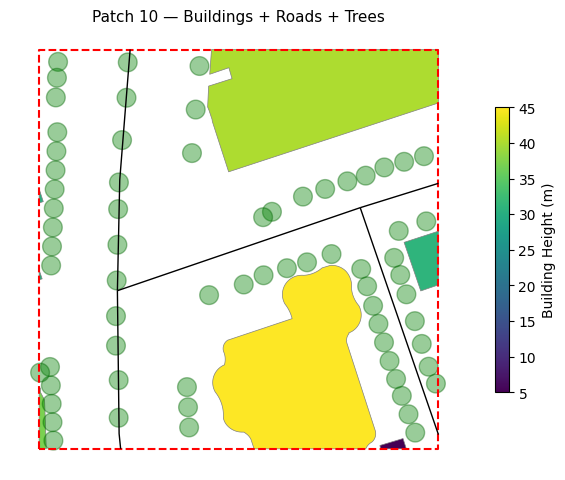

In [9]:
for i, window in enumerate(windows_gdf.geometry):
    fig, ax = plt.subplots(figsize=(6, 6))

    # === Clip data to patch window ===
    clipped_roads = roads_gdf[roads_gdf.intersects(window)].copy().clip(window)
    clipped_buildings = buildings_gdf[buildings_gdf.intersects(window)].copy().clip(window)
    clipped_trees = trees_gdf[trees_gdf.intersects(window)].copy()

    # === Compute building height (if Z_MAX_VOL and Z_MIN_VOL exist) ===
    if 'Z_MAX_VOL' in clipped_buildings.columns and 'Z_MIN_VOL' in clipped_buildings.columns:
        clipped_buildings["height"] = clipped_buildings["Z_MAX_VOL"] - clipped_buildings["Z_MIN_VOL"]
    else:
        clipped_buildings["height"] = 0

    # === Plot patch boundary ===
    gpd.GeoSeries(window).boundary.plot(ax=ax, color="red", linestyle="--")

    # === Plot buildings colored by height ===
    if not clipped_buildings.empty:
        clipped_buildings.plot(
            ax=ax,
            column="height",
            cmap="viridis",
            linewidth=0.5,
            edgecolor="gray",
            legend=True,
            legend_kwds={"label": "Building Height (m)", "shrink": 0.5}
        )

    # === Plot roads ===
    if not clipped_roads.empty:
        clipped_roads.plot(ax=ax, color="black", linewidth=1)

    # === Plot tree canopies as 3m radius circles ===
    if not clipped_trees.empty:
        tree_canopies = clipped_trees.geometry.buffer(3.0)
        gpd.GeoSeries(tree_canopies).plot(
            ax=ax,
            facecolor="green",
            edgecolor="darkgreen",
            alpha=0.4,
            label="Tree Canopy"
        )

    # === Finalize plot ===
    ax.set_title(f"Patch {i+1} — Buildings + Roads + Trees", fontsize=11)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



In [18]:
def export_geojson_with_top_keys(gdf, out_path, patch_id, features_type):
    geojson_dict = json.loads(gdf.to_json())
    geojson_dict["patch_id"] = patch_id
    geojson_dict["features_type"] = features_type
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(geojson_dict, f, indent=2)

# === Output base path ===
output_dir = Path("C:/Users/Ardo/Desktop/thesis2/patches_new")
output_dir.mkdir(exist_ok=True)

# === Grid resolution and size ===
grid_size = 128  # pixels
patch_size = 128  # meters
pixel_size = patch_size / grid_size  # 1 meter per pixel

for i, window in enumerate(windows_gdf.geometry):
    patch_id = windows_gdf.iloc[i]["C_Tram"]  # Or use your own patch_id field if you prefer
    patch_name = f"patch_{i+1:03d}_{patch_id}"
    patch_path = output_dir / patch_name
    patch_path.mkdir(exist_ok=True)

    # === Clip data to patch window ===
    clipped_roads = roads_gdf[roads_gdf.intersects(window)].copy().clip(window)
    clipped_buildings = buildings_gdf[buildings_gdf.intersects(window)].copy().clip(window)
    clipped_trees = trees_gdf[trees_gdf.intersects(window)].copy()

    # === Compute building heights, if missing ===
    if "height" not in clipped_buildings.columns:
        if 'Z_MAX_VOL' in clipped_buildings.columns and 'Z_MIN_VOL' in clipped_buildings.columns:
            clipped_buildings["height"] = clipped_buildings["Z_MAX_VOL"] - clipped_buildings["Z_MIN_VOL"]
        else:
            clipped_buildings["height"] = 0

    # === Raster transform ===
    minx, miny, maxx, maxy = window.bounds
    transform = from_origin(minx, maxy, pixel_size, pixel_size)

    # === Initialize empty DSMs ===
    dsm = np.zeros((grid_size, grid_size), dtype=np.float32)
    tree_dsm = np.zeros((grid_size, grid_size), dtype=np.float32)

    # === Rasterize buildings ===
    for _, building in clipped_buildings.iterrows():
        if building.geometry.is_valid:
            height = building.get("height", 0)
            if height > 0:
                mask = features.geometry_mask(
                    [building.geometry],
                    transform=transform,
                    invert=True,
                    out_shape=(grid_size, grid_size)
                )
                dsm[mask] = np.maximum(dsm[mask], height)

    # === Rasterize tree canopies ===
    for _, tree in clipped_trees.iterrows():
        if tree.geometry.is_valid:
            tree_height = tree.get("height", 5)
            if tree_height <= 0:
                continue
            canopy = tree.geometry.buffer(3.0)
            mask = features.geometry_mask(
                [canopy],
                transform=transform,
                invert=True,
                out_shape=(grid_size, grid_size)
            )
            tree_dsm[mask] = np.maximum(tree_dsm[mask], tree_height)

    # === Combine DSM + Tree DSM into Canopy DSM ===
    building_mask = dsm > 0
    tree_dsm[building_mask] = 0
    cdsm = tree_dsm.copy()

    # === Save DSMs ===
    dsm_path = patch_path / "dsm.tif"
    cdsm_path = patch_path / "cdsm.tif"
    dem_path = patch_path / "dem.tif"

    with rasterio.open(
        dsm_path, 'w',
        driver='GTiff',
        height=grid_size, width=grid_size, count=1, dtype='float32',
        crs='EPSG:25831', transform=transform
    ) as dst:
        dst.write(dsm, 1)

    with rasterio.open(
        cdsm_path, 'w',
        driver='GTiff',
        height=grid_size, width=grid_size, count=1, dtype='float32',
        crs='EPSG:25831', transform=transform
    ) as dst:
        dst.write(cdsm, 1)

    dem = np.zeros((grid_size, grid_size), dtype=np.float32)
    with rasterio.open(
        dem_path, 'w',
        driver='GTiff',
        height=grid_size, width=grid_size, count=1, dtype='float32',
        crs='EPSG:25831', transform=transform
    ) as dst:
        dst.write(dem, 1)

    # === Export per-patch GeoJSONs with top-level keys ===
    export_geojson_with_top_keys(clipped_buildings, patch_path / "buildings.geojson", patch_id, "Building")
    export_geojson_with_top_keys(clipped_roads, patch_path / "roads.geojson", patch_id, "Street")
    export_geojson_with_top_keys(clipped_trees, patch_path / "trees.geojson", patch_id, "Tree")
    window_gdf = gpd.GeoDataFrame({'geometry': [window]}, crs=roads_gdf.crs)
    export_geojson_with_top_keys(window_gdf, patch_path / "window.geojson", patch_id, "Window")

    # === COMBINED GEOJSON PER PATCH (all geometry types together) ===
    combined_patch_features = []

    # Add buildings
    if not clipped_buildings.empty:
        b = clipped_buildings.copy()
        b["features_type"] = "Building"
        b["patch_id"] = patch_id
        combined_patch_features.append(b)

    # Add roads
    if not clipped_roads.empty:
        r = clipped_roads.copy()
        r["features_type"] = "Street"
        r["patch_id"] = patch_id
        combined_patch_features.append(r)

    # Add trees
    if not clipped_trees.empty:
        t = clipped_trees.copy()
        t["features_type"] = "Tree"
        t["patch_id"] = patch_id
        combined_patch_features.append(t)

    # Add window as a polygon feature
    window_gdf_combined = gpd.GeoDataFrame(
        {'features_type': ["Window"], 'patch_id': [patch_id], 'geometry': [window]},
        crs=roads_gdf.crs
    )
    combined_patch_features.append(window_gdf_combined)

    # Combine all features into a single GeoDataFrame
    combined_patch_gdf = pd.concat(combined_patch_features, ignore_index=True)
    combined_patch_gdf = gpd.GeoDataFrame(combined_patch_gdf, geometry="geometry", crs=roads_gdf.crs)

    # Export to GeoJSON (as a FeatureCollection)
    combined_patch_gdf.to_file(patch_path / "patch_combined.geojson", driver="GeoJSON")

    # === Save vector-layer map visualization ===
    fig, ax = plt.subplots(figsize=(6, 6))
    gpd.GeoSeries(window).boundary.plot(ax=ax, color="red", linestyle="--", linewidth=2)
    if not clipped_buildings.empty:
        clipped_buildings.plot(
            ax=ax,
            column="height",
            cmap="viridis",
            linewidth=0.5,
            edgecolor="gray",
            legend=True,
            legend_kwds={"label": "Building Height (m)", "shrink": 0.5}
        )
    if not clipped_roads.empty:
        clipped_roads.plot(ax=ax, color="black", linewidth=1)
    if not clipped_trees.empty:
        tree_canopies = clipped_trees.geometry.buffer(3.0)
        gpd.GeoSeries(tree_canopies).plot(
            ax=ax,
            facecolor="green",
            edgecolor="darkgreen",
            alpha=0.4,
            label="Tree Canopy"
        )
    ax.set_title(f"Patch {i+1} — patch_id: {patch_id}")
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(patch_path / "patch.png", dpi=200, bbox_inches='tight')
    plt.close(fig)

    print(f"✔ Saved patch {i+1:03d} and combined GeoJSON")


✔ Saved patch 001 and combined GeoJSON
✔ Saved patch 002 and combined GeoJSON
✔ Saved patch 003 and combined GeoJSON
✔ Saved patch 004 and combined GeoJSON
✔ Saved patch 005 and combined GeoJSON
✔ Saved patch 006 and combined GeoJSON
✔ Saved patch 007 and combined GeoJSON
✔ Saved patch 008 and combined GeoJSON
✔ Saved patch 009 and combined GeoJSON
✔ Saved patch 010 and combined GeoJSON
